# Installs & Imports

In [1]:
!pip install -q lightning pytorch-forecasting

In [2]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from pytorch_forecasting import (
    NHiTS,
    TemporalFusionTransformer,
    DeepAR,
    NBeats,
    TimeSeriesDataSet,
    GroupNormalizer
)
from pytorch_forecasting.metrics import MAE, SMAPE, RMSE
from pytorch_forecasting.metrics.distributions import NormalDistributionLoss
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

# Set global plotting style
sns.set(style="whitegrid")
%matplotlib inline

# Set random seed
pl.seed_everything(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

# Data Loading

In [3]:
def load_dataset(url):
    """
    Loads a time series dataset from a given URL.

    Args:
        url (str): URL to the CSV dataset.

    Returns:
        pd.DataFrame: Loaded dataset.
    """
    try:
        data = pd.read_csv(url, parse_dates=['Date'])
        print("Data loaded successfully.\n")
    except Exception as e:
        print(f"An error occurred while loading data: {e}")
        data = None
    return data

In [4]:
# URL of the dataset: Daily Minimum Temperatures
dataset_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"

# Load the dataset
data = load_dataset(dataset_url)

# Display the dataset
display(data.head())

Data loaded successfully.



,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


# Data Exploration

First Five Rows of the Dataset:


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8



Data Summary:
                      Date         Temp
count                 3650  3650.000000
mean   1985-12-31 07:12:00    11.177753
min    1981-01-01 00:00:00     0.000000
25%    1983-07-02 06:00:00     8.300000
50%    1985-12-31 12:00:00    11.000000
75%    1988-06-30 18:00:00    14.000000
max    1990-12-31 00:00:00    26.300000
std                    NaN     4.071837

Missing Values:
Date    0
Temp    0
dtype: int64


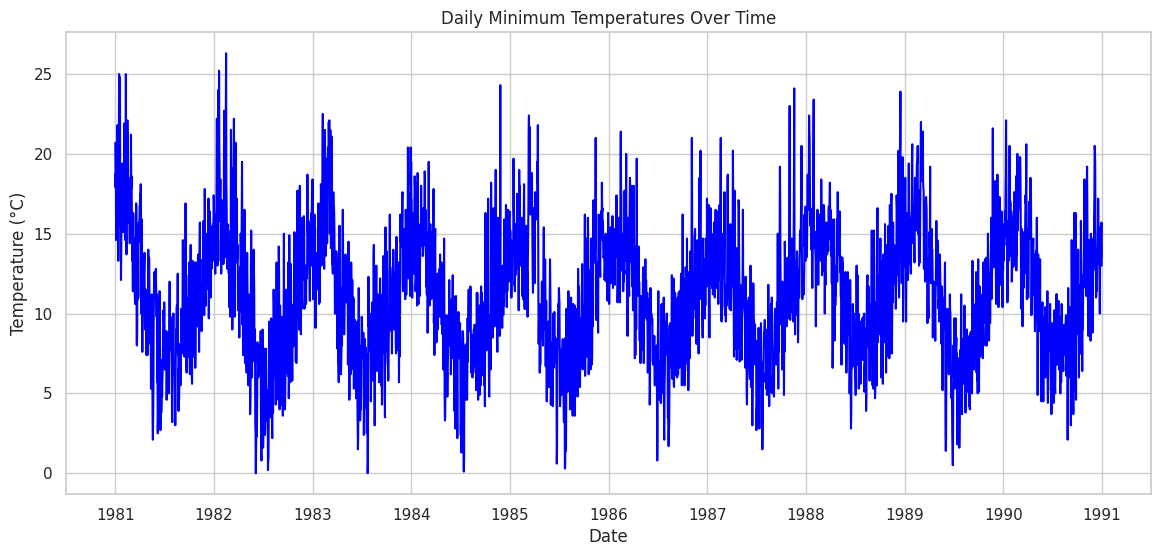

Augmented Dickey-Fuller Test: Daily Minimum Temperatures
ADF Test Statistic               -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
=> The series is stationary.



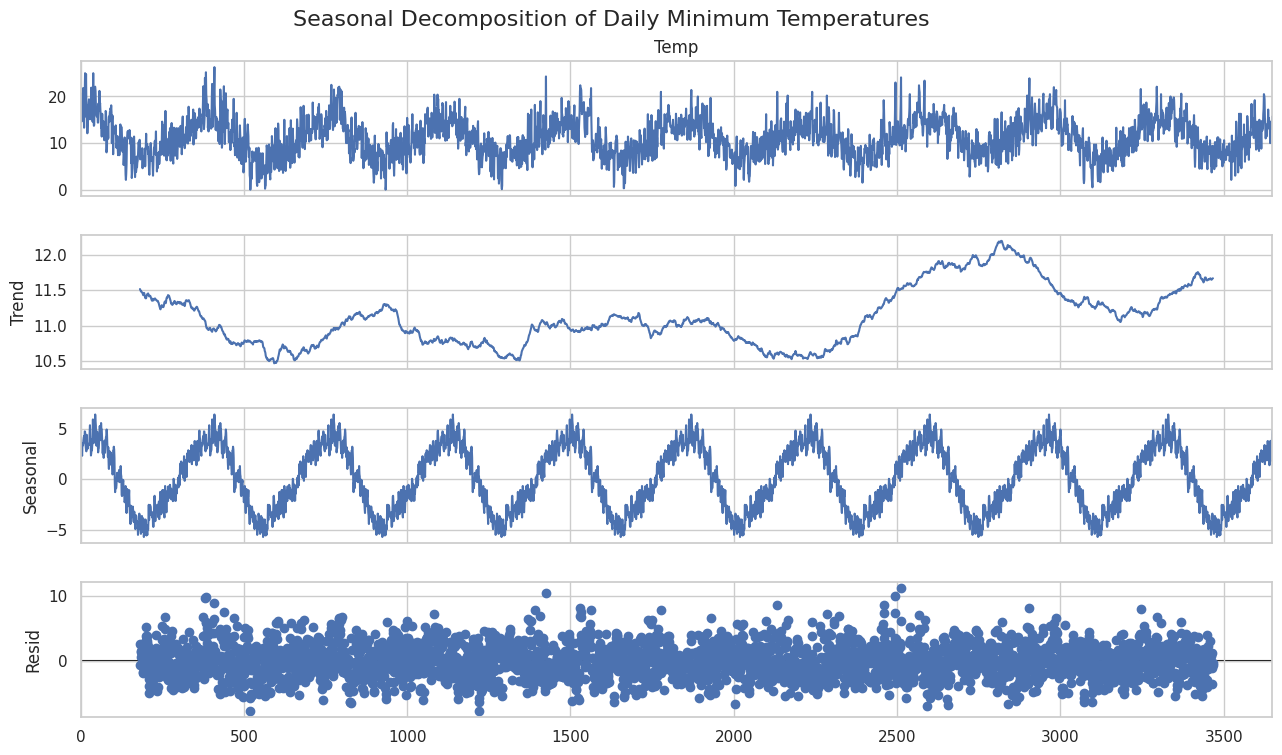

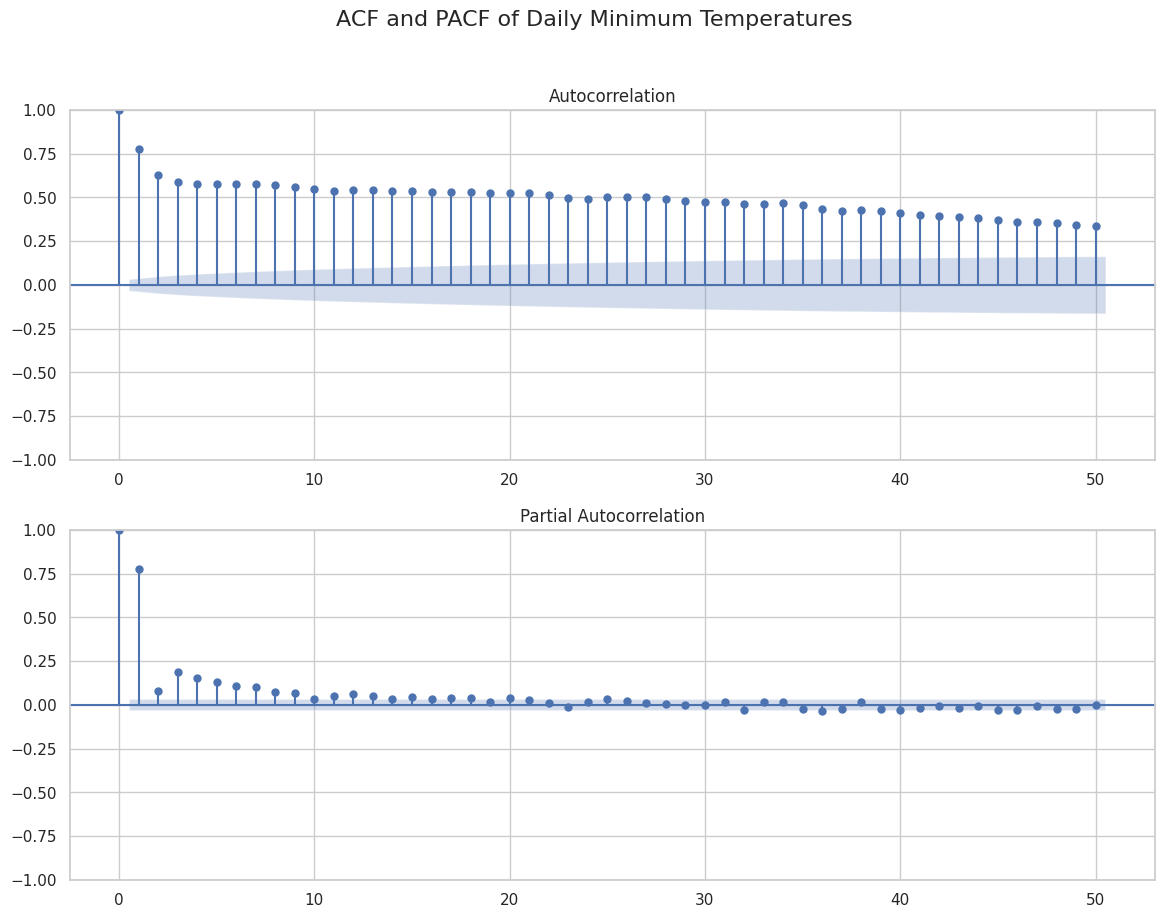

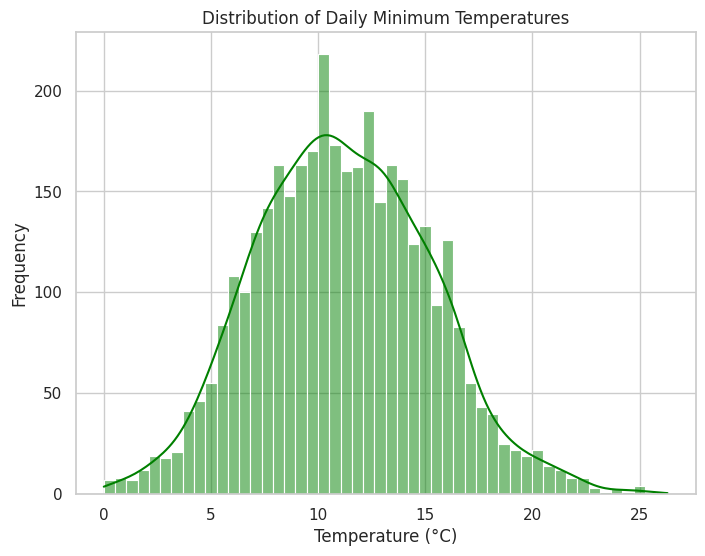

In [5]:
def explore_data(data):
    """
    Performs exploratory data analysis on the loaded dataset.

    Args:
        data (pd.DataFrame): The loaded dataset.
    """
    # Display first few rows
    print("First Five Rows of the Dataset:")
    display(data.head())

    # Basic statistics
    print("\nData Summary:")
    print(data.describe())

    # Check for missing values
    print("\nMissing Values:")
    print(data.isnull().sum())

    # Plot daily temperatures over time
    plt.figure(figsize=(14, 6))
    plt.plot(data['Date'], data['Temp'], color='blue')
    plt.title("Daily Minimum Temperatures Over Time")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.show()

    # Stationarity Check using Augmented Dickey-Fuller Test
    def adf_test(series, title=''):
        """
        Perform Augmented Dickey-Fuller test and print the results.
        """
        print(f'Augmented Dickey-Fuller Test: {title}')
        result = adfuller(series)
        labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
        out = pd.Series(result[0:4], index=labels)
        for key, value in result[4].items():
            out[f'Critical Value ({key})'] = value
        print(out.to_string())
        if result[1] <= 0.05:
            print("=> The series is stationary.\n")
        else:
            print("=> The series is non-stationary.\n")

    adf_test(data['Temp'], title='Daily Minimum Temperatures')

    # Seasonality Check using Seasonal Decomposition
    def seasonal_decomposition_plot(series, period=365, title=''):
        """
        Perform seasonal decomposition and plot the components.
        """
        decomposition = seasonal_decompose(series, model='additive', period=period)
        fig = decomposition.plot()
        fig.set_size_inches(14, 8)
        plt.suptitle(f"Seasonal Decomposition of {title}", fontsize=16)
        plt.show()

    seasonal_decomposition_plot(data['Temp'], period=365, title='Daily Minimum Temperatures')

    # Autocorrelation Check using ACF and PACF plots
    def plot_acf_pacf_plots(series, lags=50, title=''):
        """
        Plot ACF and PACF for the given series.
        """
        fig, ax = plt.subplots(2,1, figsize=(14,10))
        plot_acf(series, lags=lags, ax=ax[0])
        plot_pacf(series, lags=lags, ax=ax[1])
        plt.suptitle(f"ACF and PACF of {title}", fontsize=16)
        plt.show()

    plot_acf_pacf_plots(data['Temp'], lags=50, title='Daily Minimum Temperatures')

    # Distribution of temperatures
    plt.figure(figsize=(8, 6))
    sns.histplot(data['Temp'], bins=50, kde=True, color='green')
    plt.title("Distribution of Daily Minimum Temperatures")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Frequency")
    plt.show()

# Perform data exploration
explore_data(data)

# Data Preprocessing

In [6]:
def preprocess_data(data, target='Temp', group_id='series',
                   min_encoder_length=60, max_encoder_length=60,
                   min_prediction_length=30, max_prediction_length=30,
                   batch_size=128, model_type='Other'):
    """
    Preprocesses the data for time series forecasting using pytorch_forecasting.

    Args:
        data (pd.DataFrame): The raw dataset.
        target (str): The target variable for forecasting.
        group_id (str): Identifier for different time series groups.
        min_encoder_length (int): Minimum length of history used for forecasting.
        max_encoder_length (int): Maximum length of history used for forecasting.
        min_prediction_length (int): Minimum length of prediction horizon.
        max_prediction_length (int): Maximum length of prediction horizon.
        batch_size (int): Batch size for dataloaders.
        model_type (str): Type of the model ('NBeats', 'NHiTS', 'Other').

    Returns:
        Tuple: (training_dataset, training_dataloader, validation_dataset, validation_dataloader, test_dataset, test_dataloader)
    """
    # Assign a single group ID since it's a univariate time series
    data[group_id] = "all"

    # Sort data by date to ensure chronological order
    data = data.sort_values("Date").reset_index(drop=True)

    # Add 'time_idx' if not present
    if 'time_idx' not in data.columns:
        data['time_idx'] = np.arange(len(data))

    # Perform time-aware split: 70% train, 15% validation, 15% test
    n = len(data)
    train_end = int(n * 0.7)
    val_end = int(n * 0.85)

    train_data = data.iloc[:train_end].copy()
    val_data = data.iloc[train_end:val_end].copy()
    test_data = data.iloc[val_end:].copy()

    print(f"Training data points: {len(train_data)}")
    print(f"Validation data points: {len(val_data)}")
    print(f"Test data points: {len(test_data)}\n")

    # Define arguments based on model_type
    if model_type == 'NHiTS':
        lags = {target: [1, 7, 14, 30]}
        add_relative_time_idx = False
        time_varying_unknown_reals = [target]
    else:  # Other models like DeepAR and TFT
        lags = {target: [1, 7, 14, 30]}
        add_relative_time_idx = True
        time_varying_unknown_reals = [target]

    # Create the training TimeSeriesDataSet
    training_dataset = TimeSeriesDataSet(
        train_data,
        time_idx="time_idx",
        target=target,
        group_ids=[group_id],
        min_encoder_length=min_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=min_prediction_length,
        max_prediction_length=max_prediction_length,
        time_varying_known_categoricals=[],
        time_varying_known_reals=[],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=time_varying_unknown_reals,
        scalers={},
        lags=lags,
        add_relative_time_idx=add_relative_time_idx,
        add_target_scales=False,
        add_encoder_length=False,
        target_normalizer=GroupNormalizer(groups=[group_id])
    )

    # Create the validation TimeSeriesDataSet from the training dataset
    validation_dataset = TimeSeriesDataSet.from_dataset(
        training_dataset,
        val_data,
        predict=False,
        stop_randomization=True
    )

    # Create the test TimeSeriesDataSet in predict mode
    test_dataset = TimeSeriesDataSet(
        test_data,
        time_idx="time_idx",
        target=target,
        group_ids=[group_id],
        min_encoder_length=min_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=min_prediction_length,
        max_prediction_length=max_prediction_length,
        time_varying_known_categoricals=[],
        time_varying_known_reals=[],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=time_varying_unknown_reals,
        scalers={},
        lags=lags,
        add_relative_time_idx=add_relative_time_idx,
        add_target_scales=False,
        add_encoder_length=False,
        predict_mode=True
    )

    # Create dataloaders for training, validation, and test
    training_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
    validation_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=4)
    test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

    print("Data Preprocessing Completed.\n")

    return training_dataset, training_dataloader, validation_dataset, validation_dataloader, test_dataset, test_dataloader

In [7]:
# Preprocess data for NHiTS
training_dataset_nhits, training_dataloader_nhits, validation_dataset_nhits, validation_dataloader_nhits, test_dataset_nhits, test_dataloader_nhits = preprocess_data(
    data,
    target='Temp',
    group_id='series',
    min_encoder_length=60,
    max_encoder_length=60,
    min_prediction_length=30,
    max_prediction_length=30,
    batch_size=128,
    model_type='NHiTS'
)

Training data points: 2555
Validation data points: 547
Test data points: 548

Data Preprocessing Completed.



In [8]:
# Preprocess data for Other Models like DeepAR and TFT
training_dataset_other, training_dataloader_other, validation_dataset_other, validation_dataloader_other, test_dataset_other, test_dataloader_other = preprocess_data(
    data,
    target='Temp',
    group_id='series',
    min_encoder_length=60,
    max_encoder_length=60,
    min_prediction_length=30,
    max_prediction_length=30,
    batch_size=128,
    model_type='Other'
)

Training data points: 2555
Validation data points: 547
Test data points: 548

Data Preprocessing Completed.



In [9]:
def inspect_dataset(dataset, model_type):
    print(f"--- Inspecting Dataset for {model_type} ---")
    print("Time Varying Unknown Reals:", dataset.time_varying_unknown_reals)
    print("Target Variable:", dataset.target)
    print("Reals:", dataset.reals)
    print("Categoricals:", dataset.categoricals)
    print("Static Reals:", dataset.static_reals)
    print("Static Categoricals:", dataset.static_categoricals)
    print("----------------------------------------\n")

In [10]:
# Inspect NHiTS Dataset
inspect_dataset(training_dataset_nhits, 'NHiTS')

# Inspect Other Models Dataset
inspect_dataset(training_dataset_other, 'Other Models')

--- Inspecting Dataset for NHiTS ---
Time Varying Unknown Reals: ['Temp', 'Temp_lagged_by_1', 'Temp_lagged_by_7', 'Temp_lagged_by_14']
Target Variable: Temp
Reals: ['Temp_lagged_by_30', 'Temp', 'Temp_lagged_by_1', 'Temp_lagged_by_7', 'Temp_lagged_by_14']
Categoricals: []
Static Reals: []
Static Categoricals: []
----------------------------------------

--- Inspecting Dataset for Other Models ---
Time Varying Unknown Reals: ['Temp', 'Temp_lagged_by_1', 'Temp_lagged_by_7', 'Temp_lagged_by_14']
Target Variable: Temp
Reals: ['relative_time_idx', 'Temp_lagged_by_30', 'Temp', 'Temp_lagged_by_1', 'Temp_lagged_by_7', 'Temp_lagged_by_14']
Categoricals: []
Static Reals: []
Static Categoricals: []
----------------------------------------



# Model Training

In [11]:
def train_model(model_type, training_dataset, validation_dataset,
               learning_rate=1e-3, weight_decay=1e-2, hidden_size=128,
               dropout=0.1, attention_head_size=4, hidden_continuous_size=128,
               backcast_loss_ratio=0.1, loss_function=None, batch_size=128,
               patience=10, **kwargs):
    """
    Trains a specified model and returns the trained model.

    Args:
        model_type (str): Type of the model ('NHiTS', 'DeepAR', 'TFT').
        training_dataset (TimeSeriesDataSet): Training dataset.
        validation_dataset (TimeSeriesDataSet): Validation dataset.
        **kwargs: Additional model-specific parameters.

    Returns:
        Trained model instance.
    """
    # Set default loss functions based on model type
    if loss_function is None:
        if model_type in ['DeepAR']:
            loss_function = NormalDistributionLoss()
        else:
            loss_function = SMAPE()

    # Initialize the model based on model_type
    if model_type == 'NHiTS':
        model = NHiTS.from_dataset(
            training_dataset,
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            loss=loss_function,
            backcast_loss_ratio=backcast_loss_ratio,
            hidden_size=hidden_size,
            optimizer="AdamW",
            dropout=dropout,
            **kwargs
        )
    elif model_type == 'TFT':
        model = TemporalFusionTransformer.from_dataset(
            training_dataset,
            learning_rate=learning_rate,
            hidden_size=hidden_size,
            attention_head_size=attention_head_size,
            dropout=dropout,
            hidden_continuous_size=hidden_continuous_size,
            output_size=1,  # for regression
            loss=loss_function,
            log_interval=10,
            reduce_on_plateau_patience=4,
            optimizer="AdamW",
            **kwargs
        )
    elif model_type == 'DeepAR':
        model = DeepAR.from_dataset(
            training_dataset,
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            loss=loss_function,
            hidden_size=hidden_size,
            optimizer="AdamW",
            cell_type='LSTM',
            rnn_layers=2,
            **kwargs
        )
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Define callbacks
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=patience, mode="min")
    checkpoint_callback = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min")

    # Initialize Logger
    logger = TensorBoardLogger("lightning_logs", name=model_type)

    # Initialize Trainer with Logger
    trainer = pl.Trainer(
        max_epochs=50,
        accelerator="auto",
        devices=1 if torch.cuda.is_available() else None,
        gradient_clip_val=0.1,
        callbacks=[early_stop_callback, checkpoint_callback],
        logger=logger,  # Use the TensorBoardLogger
        enable_progress_bar=True,
    )

    # Train the model
    trainer.fit(
        model,
        train_dataloaders=training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=4),
        val_dataloaders=validation_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=4),
    )

    # Load the best model
    best_model_path = checkpoint_callback.best_model_path
    best_model = type(model).load_from_checkpoint(best_model_path)
    print(f"Best model saved at: {best_model_path}\n")

    return best_model

In [12]:
# Initialize a dictionary to store trained models
trained_models = {}

# Train NHiTS model
print("### Training NHiTS Model ###")
trained_nhits = train_model(
    model_type='NHiTS',
    training_dataset=training_dataset_nhits,
    validation_dataset=validation_dataset_nhits,
    learning_rate=1e-3,
    weight_decay=1e-2,
    hidden_size=128,
    backcast_loss_ratio=0.1,
    batch_size=128,
    patience=10
)
trained_models['NHiTS'] = trained_nhits

### Training NHiTS Model ###


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | SMAPE          | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 191 K  | train
-----------------------------------------------------------
191 K     Trainable params
0         Non-trainable params
191 K     Total params
0.765     Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Best model saved at: lightning_logs/NHiTS/version_2/checkpoints/epoch=7-step=152.ckpt



In [13]:
# Train TFT model
print("\n### Training Temporal Fusion Transformer (TFT) Model ###")
trained_tft = train_model(
    model_type='TFT',
    training_dataset=training_dataset_other,
    validation_dataset=validation_dataset_other,
    learning_rate=1e-3,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=128,
    batch_size=128,
    patience=10
)
trained_models['TFT'] = trained_tft

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | SMAPE                           | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 1.5 K  | train
4  | static_variable_selection          | VariableSelectionNetwor


### Training Temporal Fusion Transformer (TFT) Model ###


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Best model saved at: lightning_logs/TFT/version_2/checkpoints/epoch=4-step=95.ckpt



In [14]:
# Train DeepAR model
print("\n### Training DeepAR Model ###")
trained_depar = train_model(
    model_type='DeepAR',
    training_dataset=training_dataset_other,
    validation_dataset=validation_dataset_other,
    learning_rate=1e-3,
    weight_decay=1e-2,
    hidden_size=128,
    batch_size=128,
    patience=10
)
trained_models['DeepAR'] = trained_depar

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                   | Type                   | Params | Mode 
--------------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0      | train
1 | logging_metrics        | ModuleList             | 0      | train
2 | embeddings             | MultiEmbedding         | 0      | train
3 | rnn                    | LSTM                   | 201 K  | train
4 | distribution_projector | Linear                 | 258    | train
--------------------------------------------------------------------------
201 K     Trainable params
0         Non-trainable pa


### Training DeepAR Model ###


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Best model saved at: lightning_logs/DeepAR/version_2/checkpoints/epoch=11-step=228.ckpt



# Model Evaluation

In [15]:
# Initialize a dictionary to store evaluation metrics
evaluation_results = {}

# Initialize a dictionary to store aligned predictions for each model
predictions_dict = {}

# Initialize a list to store actual values
actual_values = []

# Evaluate each model
for model_name, model in trained_models.items():
    print(f"### Evaluating {model_name} Model ###")

    # Select the appropriate test dataloader
    test_dataloader_selected = test_dataloader_nhits if model_name == 'NHiTS' else test_dataloader_other

    try:
        # Generate predictions
        predictions = model.predict(
            test_dataloader_selected,
            trainer_kwargs=dict(accelerator="cpu"),
            return_y=True
        )

        # Store predictions
        predictions_dict[model_name] = predictions.output.squeeze().tolist()

        # Store actual values
        if not actual_values:
            actual_values = predictions.y[0]
            actual_values = actual_values.squeeze().tolist()

        # Compute evaluation metrics
        mae = MAE()(predictions.output, predictions.y)
        rmse = RMSE()(predictions.output, predictions.y)
        smape = SMAPE()(predictions.output, predictions.y)

        # Store the metrics
        evaluation_results[model_name] = {
            'MAE': mae.item(),
            'RMSE': rmse.item(),
            'SMAPE': smape.item()
        }

        print(f"Metrics for {model_name}: MAE={mae.item()}, RMSE={rmse.item()}, SMAPE={smape.item()}\n")

    except Exception as e:
        print(f"Error evaluating {model_name} model: {e}\n")

### Evaluating NHiTS Model ###
Metrics for NHiTS: MAE=1.8377050161361694, RMSE=2.6284139156341553, SMAPE=0.1252877116203308

### Evaluating TFT Model ###
Metrics for TFT: MAE=1.9444817304611206, RMSE=2.8419156074523926, SMAPE=0.13352784514427185

### Evaluating DeepAR Model ###
Metrics for DeepAR: MAE=1.835901141166687, RMSE=2.6658236980438232, SMAPE=0.12541618943214417



In [16]:
# Create metrics DataFrame
evaluation_df = pd.DataFrame(evaluation_results).T
display(evaluation_df)

,MAE,RMSE,SMAPE
NHiTS,1.837705,2.628414,0.125288
TFT,1.944482,2.841916,0.133528
DeepAR,1.835901,2.665824,0.125416


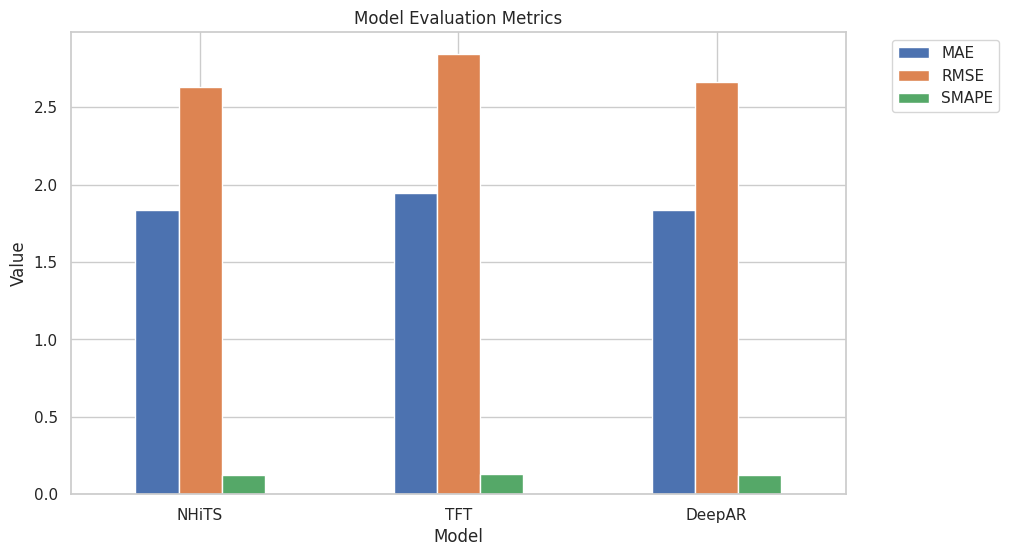

In [17]:
# Create grouped bar plot
evaluation_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Evaluation Metrics")
plt.ylabel("Value")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [18]:
# Create predictions DataFrame
predictions_df = pd.DataFrame(predictions_dict)

# Add actual values
predictions_df['Actual'] = actual_values

# Display the DataFrame
display(predictions_df)

,NHiTS,TFT,DeepAR,Actual
0,13.482537,13.140774,13.601221,13.200000
1,14.207713,13.156477,13.515034,16.200001
2,14.025352,13.113668,13.150939,17.299999
3,13.835443,13.088387,13.516106,20.500000
4,13.195780,12.904686,13.411325,20.200001
5,13.217467,13.081754,13.454299,19.400000
6,13.011803,13.567749,13.631387,15.500000
7,13.463354,13.726244,13.783211,14.100000
8,13.038149,13.576131,13.638959,11.000000
9,13.393658,13.511252,13.325784,11.100000


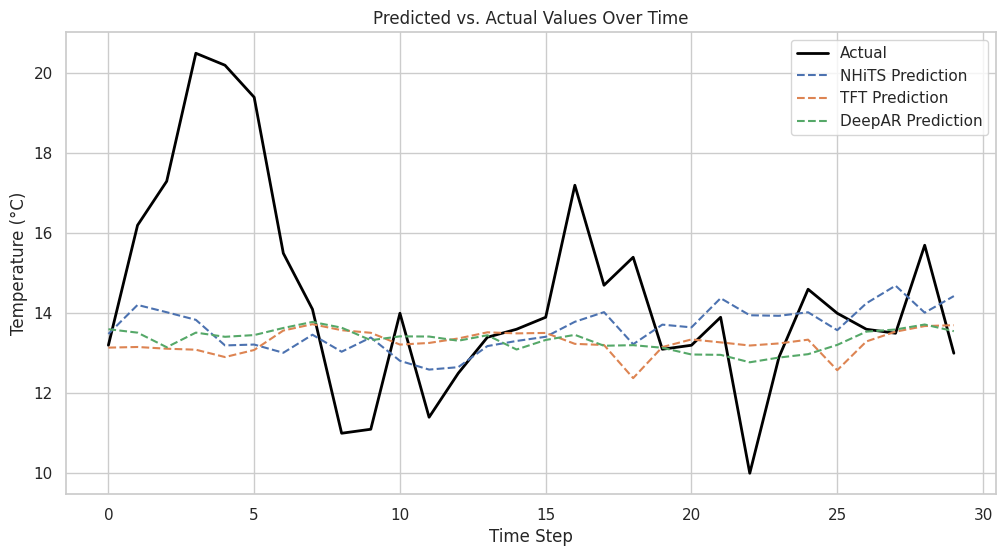

In [19]:
# Plot predictions versus actual values
plt.figure(figsize=(12, 6))

# Plot the actual values
plt.plot(predictions_df['Actual'], label='Actual', color='black', linewidth=2)

# Plot each model's predictions
for model_name in trained_models.keys():
    plt.plot(predictions_df[model_name], label=f'{model_name} Prediction', linestyle='--')

plt.title("Predicted vs. Actual Values Over Time")
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.legend(loc="best")
plt.show()